# Mario Vs. Wario Image Classifier

In [1]:
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from pytube import YouTube
from skimage.segmentation import mark_boundaries

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

import lime
from lime import lime_image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


# Downloading and Processing Mario and Wario from YouTube

In [2]:
#MARIO
mario_video = YouTube('https://youtu.be/1dMAe_6dwDs') 
print('Title:', mario_video.title, '---')
stream = mario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)
    

mario_video.streams.get_by_itag(18).download()

Title: Mario Kart Wii - 150cc Mushroom Cup Grand Prix (Mario Gameplay) ---
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2">
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d4015">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [3]:
#WARRIO
wario_video = YouTube('https://youtu.be/OvvqTnuxuwE') 
print('Title:', wario_video.title, '---')
stream = wario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)
    
wario_video.streams.get_by_itag(18).download()

Title: Mario Kart Wii - 150cc Star Cup Grand Prix (Wario Gameplay) ---
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2">
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d4015">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [4]:
def scrape_frames(video_name, dest_path, n_images, skip_seconds):
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() 
        
        if frame_count > (skip_seconds * 30):
            if not success:
                break

            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
             
def img_to_1d_greyscale(img_path, size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

def show_image(image):
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)
        

In [5]:
scrape_frames('Mario Kart Wii - 150cc Mushroom Cup Grand Prix (Mario Gameplay).mp4', 
              'training_set/mario/mario',
              n_images = 50,
              skip_seconds = 60)

In [6]:
scrape_frames('Mario Kart Wii - 150cc Star Cup Grand Prix (Wario Gameplay).mp4', 
              'training_set/wario/wario', 
              n_images = 50,
              skip_seconds = 60)

In [7]:
def move_random_files(path_from, path_to, n):
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] 

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)

In [8]:
move_random_files(path_from = 'training_set/mario/', 
                  path_to = 'test_set/mario/', 
                  n = 15)

In [9]:
move_random_files(path_from = 'training_set/wario/', 
                  path_to = 'test_set/wario/wario',
                  n = 15)

In [10]:
def preview_random_image(path):
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)

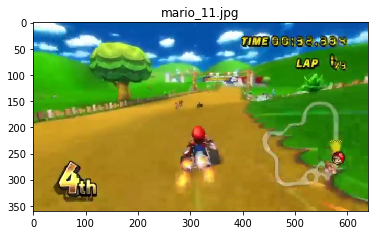

Dimensions: (640, 360) Total pixels: 230400


In [11]:

preview_random_image('training_set/mario/')

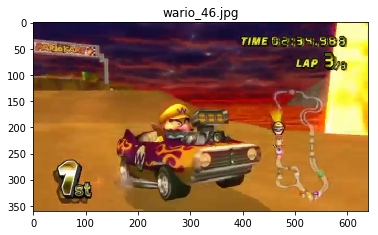

Dimensions: (640, 360) Total pixels: 230400


In [12]:
preview_random_image('training_set/wario/')

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set/',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set/',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 70 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [14]:
labels_index = { 0 : "mario", 1 : "wario" }
training_set.class_indices

{'.ipynb_checkpoints': 0, 'mario': 1, 'wario': 2}

In [15]:
files = os.listdir('training_set/mario/')
img_name = files[randint(0, len(files) - 1)]
    
img = load_img('training_set/mario/' + img_name)  

x = img_to_array(img)          
x = x.reshape((1,) + x.shape)  

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                                save_to_dir='preview', save_prefix='mario', save_format='jpeg'):
    i += 1
    if i > 20:
        break

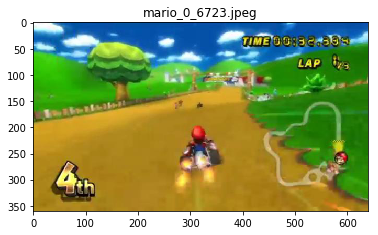

Dimensions: (640, 360) Total pixels: 230400


In [16]:
preview_random_image('preview/')

### CNN

In [17]:
cnn_classifier = Sequential()

# Layer1
cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Layer2
cnn_classifier.add(Conv2D(32, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Layer3
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
cnn_classifier.add(Flatten())

# Full connection
cnn_classifier.add(Dense(units = 64, activation = 'relu'))
cnn_classifier.add(Dropout(0.5)) # quite aggresive dropout, maybe reduce
cnn_classifier.add(Dense(units = 1, activation = 'sigmoid'))

cnn_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

In [18]:
cnn_classifier.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

cnn_classifier.fit_generator(training_set,
                             steps_per_epoch = 500,
                             epochs = 10,
                             validation_data = test_set,
                             validation_steps = 500)

Epoch 1/10
500/500 [==============================] - 228s 455ms/step - loss: -8.0164 - acc: 0.4909 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 2/10
500/500 [==============================] - 224s 447ms/step - loss: -7.9560 - acc: 0.5010 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 3/10
500/500 [==============================] - 230s 460ms/step - loss: -8.0650 - acc: 0.4941 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 4/10
500/500 [==============================] - 224s 448ms/step - loss: -7.8257 - acc: 0.5091 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 5/10
500/500 [==============================] - 229s 457ms/step - loss: -7.9433 - acc: 0.5017 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 6/10
500/500 [==============================] - 233s 465ms/step - loss: -7.8903 - acc: 0.5051 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 7/10
500/500 [==============================] - 225s 450ms/step - loss: -8.0736 - acc: 0.4936 - val_loss: -7.9712 - val_acc: 0.5000
Epoch 8/10
500/500 [==============

In [19]:
cnn_classifier.save_weights('mario_vs_wario_weights_dropout.h5')
cnn_classifier.save('mario_vs_wario_model_dropout.h5')

In [21]:
cnn_classifier = keras.models.load_model('mario_vs_wario_model_dropout.h5')

# Evaluate

In [22]:
size = (64, 64)
X_eval = list()
y_eval = list()

# mario part
files = os.listdir('test_set/mario')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/mario/' + files[i + 1], size))
    y_eval.append(0)

# wario part
files = os.listdir('test_set/wario')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/wario/' + files[i + 1], size))
    y_eval.append(1)

# stacking the arrays   
X_eval = np.vstack(X_eval)

In [23]:
cnn_pred = cnn_classifier.predict_classes(X_eval, batch_size = 42)

In [24]:
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

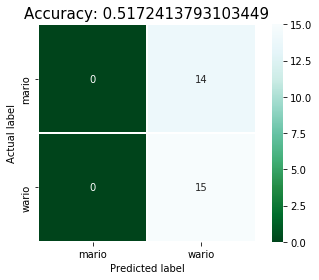

In [25]:
pretty_cm(cnn_pred, y_eval, ['mario', 'wario'])

### Explain and Visualize

In [26]:
correctly_classified_indices, misclassified_indices = evaluation_indices(cnn_pred, y_eval)

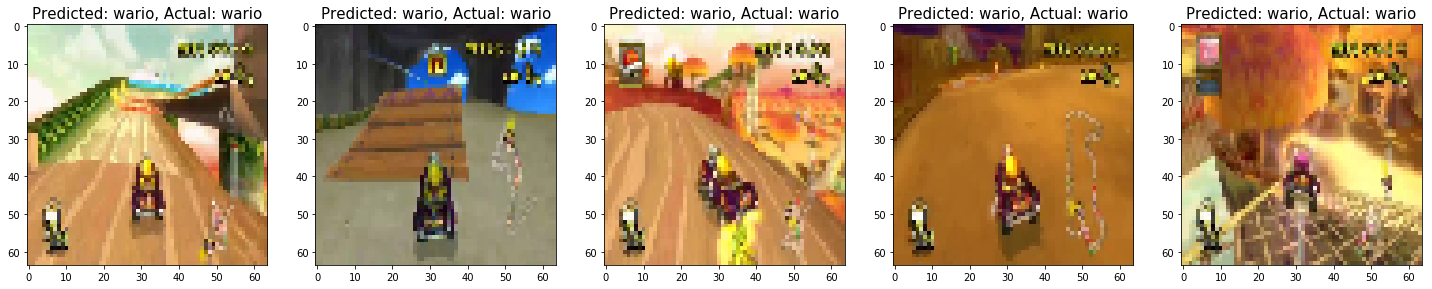

In [27]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

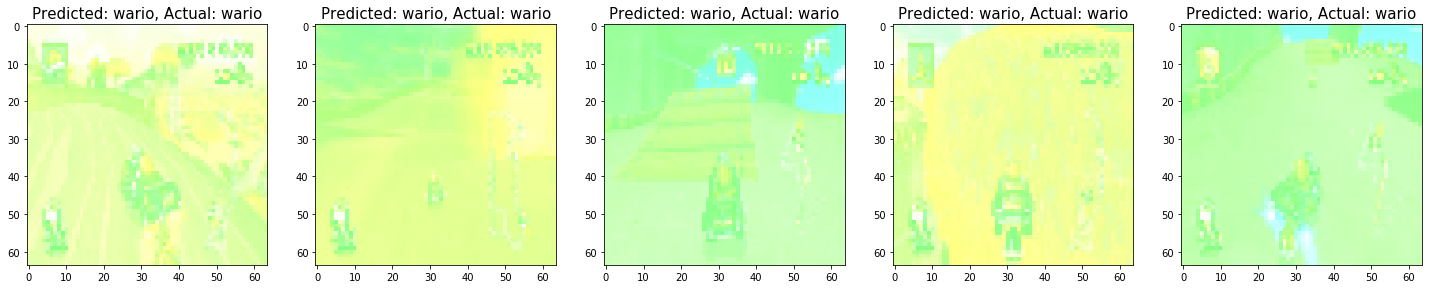

In [28]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[good_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

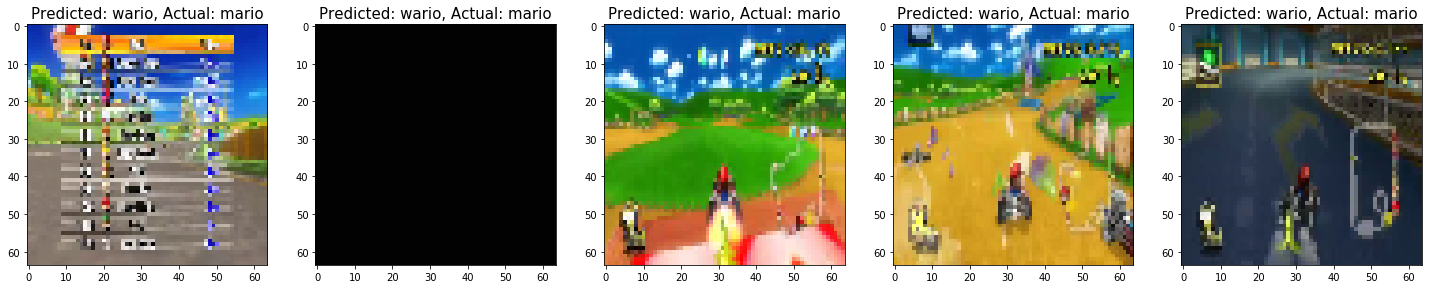

In [29]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[bad_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)

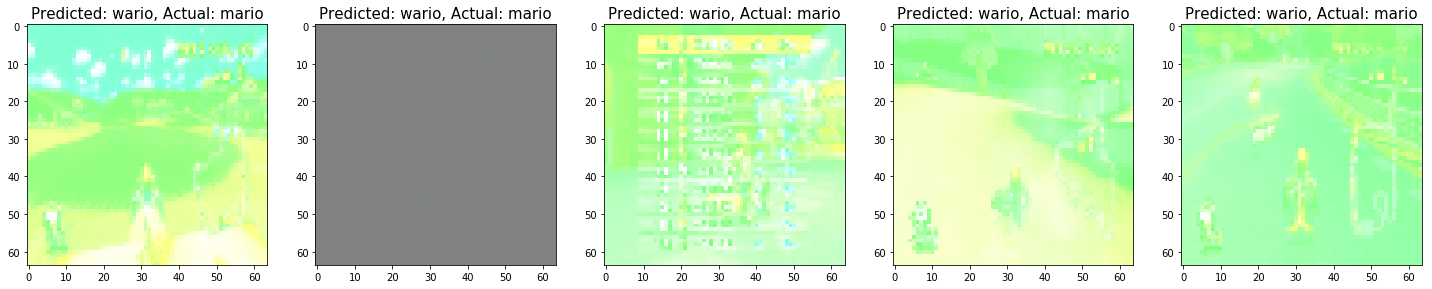

In [30]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[bad_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)